# Analyse AB test result

## Project by Manoel Revez, Lucía Olmos, Zongyue Guo, and Jake Wellian

### Objective

- An e-commerce company created a new web-page for a product, expecting customer conversion to increase. As part of their strategy they conducted an AB test. Based on the results, they would like to know if they should implement the new web-page? Or should they not? Or should they run the test longer?
- They also wanted us to build a machine learning model to predict if the user was part of the control group or the treatment group.

### Summary

- We compared the performance of the two websites using the t-test and p-value method. The result was a t-score of -0.85 and p-score of 0.39. 
- We concluded that switching to the new web page wouldn't have a significant difference on the user experience. And given that the t-test was -0.85, it is advised to continue with the old web page as is.


- With our machine learning model we found that both the XGBoost model and Adaboost model had the same accuracy score. With a F1_score of 0.987 either model could be used for future prediction.

### Data Overview

In [1]:
# Import libraries

#Libraries for EDA and visualizations
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as tick
import datetime
from datetime import timedelta

In [2]:
df_user = pd.read_csv("ab_data.csv") # user data

In [3]:
df_countries = pd.read_csv("countries.csv") # country data

In [4]:
# User data has 294'480 rows and 5 columns
df_user.shape

(294480, 5)

In [5]:
# User data has 290'586 rows and 2 columns
df_countries.shape

(290586, 2)

In [6]:
df_user.sample(10)

,user_id,timestamp,group,landing_page,converted
273544,898080,11:48.5,control,old_page,0
285225,699812,29:47.1,treatment,new_page,0
209922,744689,39:45.3,control,old_page,0
92036,688039,33:07.7,control,old_page,0
2,661590,55:06.2,treatment,new_page,0
117789,861065,18:54.2,control,old_page,0
83378,904249,39:32.8,control,old_page,0
221748,936298,12:53.3,control,old_page,0
163538,899661,07:32.2,control,old_page,0
130956,918256,23:22.5,control,old_page,0


- User data has information about the following:
    - User_id
    - timestap: time spent on the web page
    - group: if user was part of the control or treatment group
    - landing_page: if user spent time on the old page or new page
    - converted: user prefers the other web page

In [7]:
df_countries.sample(10)

,user_id,country
50322,717991,US
69449,790282,US
275283,721268,US
155084,683852,US
244751,758707,UK
80772,778053,US
255567,881341,UK
174176,689375,US
170959,894265,US
260250,830509,US


- User data has information about the following:
    - User_id
    - country

In [8]:
df_user.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294480 entries, 0 to 294479
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294480 non-null  int64 
 1   timestamp     294480 non-null  object
 2   group         294480 non-null  object
 3   landing_page  294480 non-null  object
 4   converted     294480 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


- There are 2 numerical columns in this dataset and 3 non-numerical columns.
- A few of these columns are the wrong data type
    - User_id should be a string not an interger
    - timestamp should be a date not a string
    - converted should be a boolean

In [9]:
df_countries.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290586 entries, 0 to 290585
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   user_id  290586 non-null  int64 
 1   country  290586 non-null  object
dtypes: int64(1), object(1)
memory usage: 4.4+ MB


- There is 1 numerical columns in this dataset and 1 non-numerical column.
    - User_id should be a string not an interger

### Data Pre-processing

#### Changing data types

In [10]:
#Changing user_id to the a string
df_user["user_id"] = df_user.user_id.astype(str)
df_countries["user_id"] = df_countries.user_id.astype(str)

#Chaing converted to a boolean
df_user["converted"] = df_user.converted.astype(bool)

In [11]:
#Changing timestap to a duration
df_user[['minutes', 'seconds']] = df_user['timestamp'].str.split(':', expand=True)


df_user["minutes"] = df_user.minutes.astype("int64")
df_user["seconds"] = df_user.seconds.astype(float)

#New Column Duration
df_user["duration (in seconds)"] = df_user["seconds"] + (df_user["minutes"] * 60)

In [12]:
# Drop columns used for timestamp conversation
df_user = df_user.drop(["timestamp","minutes","seconds"], axis = 1)

In [13]:
df_user.head(10)

,user_id,group,landing_page,converted,duration (in seconds)
0,851104,control,old_page,False,708.6
1,804228,control,old_page,False,105.2
2,661590,treatment,new_page,False,3306.2
3,853541,treatment,new_page,False,1683.1
4,864975,control,old_page,True,3146.2
5,936923,control,old_page,False,1249.1
6,679687,treatment,new_page,True,1606.9
7,719014,control,old_page,False,2909.5
8,817355,treatment,new_page,True,3489.0
9,839785,treatment,new_page,True,666.6


In [14]:
df_user.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294480 entries, 0 to 294479
Data columns (total 5 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   user_id                294480 non-null  object 
 1   group                  294480 non-null  object 
 2   landing_page           294480 non-null  object 
 3   converted              294480 non-null  bool   
 4   duration (in seconds)  294480 non-null  float64
dtypes: bool(1), float64(1), object(3)
memory usage: 9.3+ MB


#### Joining dataframes

In [15]:
# Group the two dataframes together using a join

df = pd.merge(df_user, df_countries, on='user_id', how='inner')

In [16]:
# Checking null values
df.isna().sum()

user_id                  0
group                    0
landing_page             0
converted                0
duration (in seconds)    0
country                  0
dtype: int64

### Exploratory Data Analysis

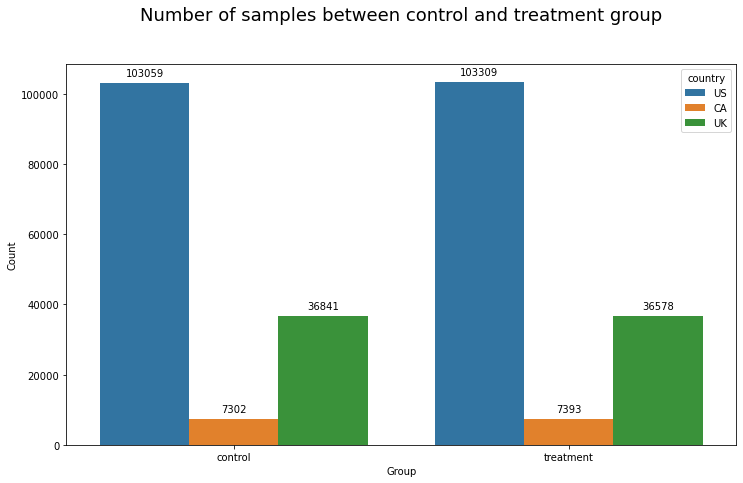

In [57]:
# Comparing number of samples between the control and treatment group
plt.figure(figsize=(12,7))

ax= sns.countplot(data=df, x="group", hue="country",)
ax.set(xlabel='Group', ylabel='Count')

plt.title("Number of samples between control and treatment group", y=1.1, fontsize=18)

for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

- Number of samples is almost the same for both groups. This will be very helpful for our A/B testing

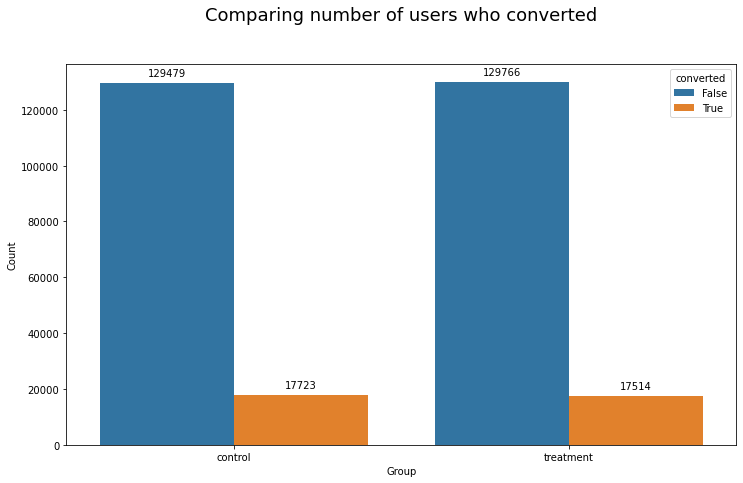

In [58]:
# How many people converted?
plt.figure(figsize=(12,7))

ax= sns.countplot(data=df, x="group", hue="converted",)
ax.set(xlabel='Group', ylabel='Count')

plt.title("Comparing number of users who converted", y=1.1, fontsize=18)

for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

- The large majority of users did not convert.
- We can also notice that the number of people from the control group who converted to the new website was the same ratio as those from the treatment group who moved to the old website.

- Number of samples is almost the same for both groups. This will be very helpful for our A/B testing

Text(0.5, 1.0, 'Relationship between time spent on web page and the group')

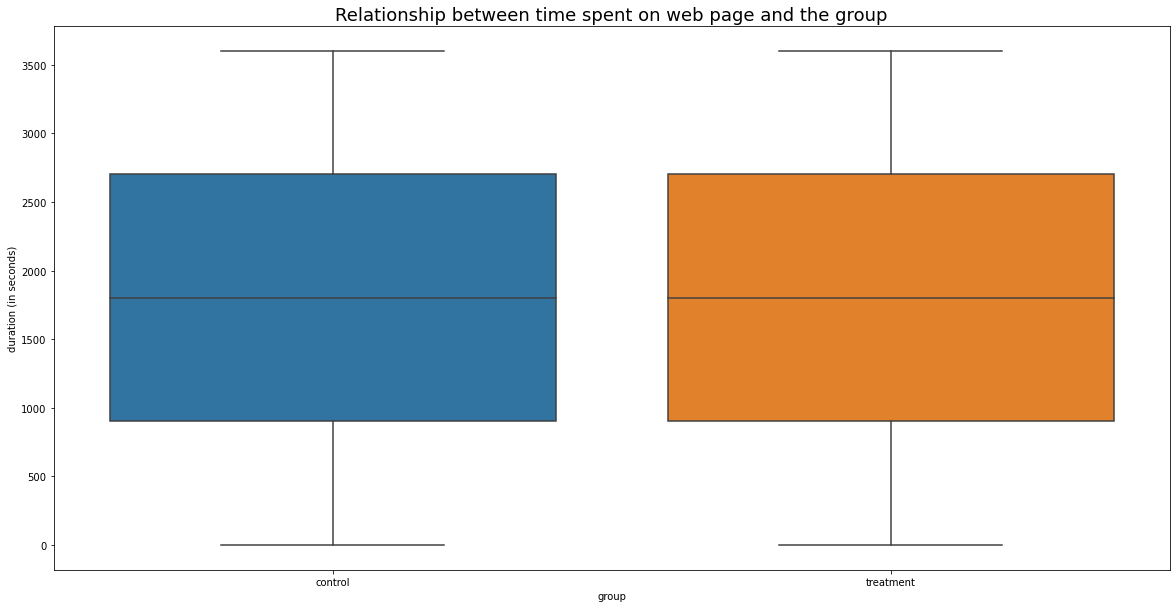

In [59]:
# Correlation between time spent on web page and group
plt.figure(figsize=(20,10))
sns.boxplot(data=df,x="group",y="duration (in seconds)")
ax = plt.gca()
plt.title("Relationship between time spent on web page and the group", fontsize=18)

- We can see that the duration spent is nearly identical for both groups.

### A/B Testing

- Our problem is to find out if the e-commerce company implement the new web page?

- The first method we will use is A/B testing. Here are the steps to perform A/B testing:
    - Step 1: Define the null and alternate hypotheses
    - Step 2: Select Appropriate test
    - Step 3: Decide the significance level
    - Step 4: Calculation
    - Step 7: Draw inference

#### Step 1: Define the null and alternate hypotheses

Let $\mu_1, \mu_2$ be the time spent on the old landing page and the new landing page respectively.

We will test the null hypothesis

>$H_0:\mu_1=\mu_2$

against the alternate hypothesis

>$H_a:\mu_1\neq\mu_2$

#### Step 2: Select Appropriate test

In [17]:
# Comparing variance between the two test groups
df["group"].value_counts()

treatment    147280
control      147202
Name: group, dtype: int64

- We have a large sample sizes and the variances are approximately equal. We can therefore perform a standard t-test

In [18]:
# Import library for t-test
from scipy.stats import ttest_ind

#### Step 3: Decide the significance level

$\alpha$ 0.05 significance level

#### Step 4: Calculation 

In [19]:
# Separate the durations for each group
treatment_durations = df[df['group'] == 'treatment']['duration (in seconds)']
control_durations = df[df['group'] == 'control']['duration (in seconds)']

# Perform a two-sample t-test
t_stat, p_value = ttest_ind(treatment_durations, control_durations, equal_var=True)

# Display the results
print("t-statistic:", t_stat)
print("p-value:", p_value)

t-statistic: -0.854423446511135
p-value: 0.3928711043741553


#### Step 4: Draw Inference 

- The result for the t-test was -0.85. These means that the control group spent more time on the old website versus the treatment group on the new website.



- The result for the p-test was 0.39. As number this is greater than 0.05 we fail to reject the null hypothesis and cannot conclude a significant difference between the two web pages.
- Testing the hypothesis further by sampling additional data is unlikely to make a difference since the t-test and p-value are based on metrics for a large sample size (n > 145000). It is therefore not recommended to continue with testing.


- As a conclusion switching to the new web page wouldn't have a significant difference on the user experience. And given that the t-test was -0.85, it is advised to continue with the old web page as is.

### Machine Learning

#### About method

In [265]:
# Import libaries for modelling

from sklearn import metrics
# To tune model, get different metric scores, and split data
from sklearn.metrics import (
    f1_score,
    accuracy_score,
    recall_score,
    precision_score,
    confusion_matrix,
    roc_auc_score,
    plot_confusion_matrix,
)
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score

from sklearn.compose import TransformedTargetRegressor
from sklearn.preprocessing import QuantileTransformer

# to check model performance
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error

# To be used for data scaling and one hot encoding
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder

# To impute missing values
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer

# To do hyperparameter tuning
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import RFE
from sklearn.model_selection import KFold

# To help with model building
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier

# To suppress warnings
import warnings

warnings.filterwarnings("ignore")

# to build linear regression_model using statsmodels
import statsmodels.api as sm

# to compute VIF
from statsmodels.stats.outliers_influence import variance_inflation_factor

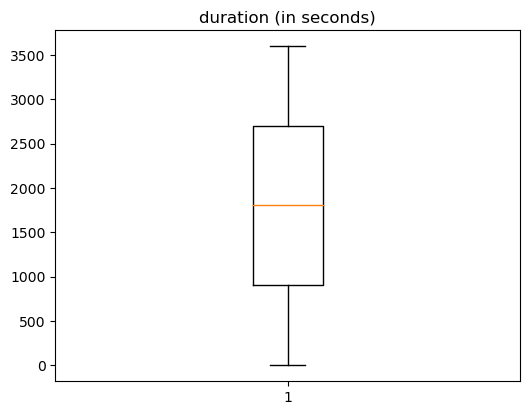

In [266]:
# Checking for outliers
out_cols = [
    item for item in df.select_dtypes(include=np.number).columns if "tag" not in item
]

plt.figure(figsize=(15, 35))

for i, variable in enumerate(out_cols):
    plt.subplot(9, 3, i + 1)
    plt.boxplot(df[variable], whis=1.5)
    plt.tight_layout()
    plt.title(variable)

plt.show()

- No outliers

In [267]:
# Converting features "group", "countries" and "landing_page" to dummy variable for model

df = pd.get_dummies(df, columns=["group","country","landing_page"], drop_first=True) 

In [268]:
# defining a function to compute different metrics to check performance of a classification model built using sklearn
def model_performance_classification_sklearn(model, predictors, target):
    """
    Function to compute different metrics to check classification model performance

    model: classifier
    predictors: independent variables
    target: dependent variable
    """

    # predicting using the independent variables
    pred = model.predict(predictors)

    acc = accuracy_score(target, pred)  # to compute Accuracy
    recall = recall_score(target, pred)  # to compute Recall
    precision = precision_score(target, pred)  # to compute Precision
    f1 = f1_score(target, pred)  # to compute F1-score

    # creating a dataframe of metrics
    df_perf = pd.DataFrame(
        {
            "Accuracy": acc,
            "Recall": recall,
            "Precision": precision,
            "F1": f1
            
        },
        index=[0],
    )

    return df_perf

In [269]:
def confusion_matrix_sklearn(model, predictors, target):
    """
    To plot the confusion_matrix with percentages

    model: classifier
    predictors: independent variables
    target: dependent variable
    """
    y_pred = model.predict(predictors)
    cm = confusion_matrix(target, y_pred)
    labels = np.asarray(
        [
            ["{0:0.0f}".format(item) + "\n{0:.2%}".format(item / cm.flatten().sum())]
            for item in cm.flatten()
        ]
    ).reshape(2, 2)

    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=labels, fmt="")
    plt.ylabel("True label")
    plt.xlabel("Predicted label")

In [270]:
# Type of scoring used to compare parameter combinations
scorer = metrics.make_scorer(metrics.f1_score)

In [271]:
# split data
X = df.drop(["group_treatment"], axis = 1) # independant variables
y = df[["group_treatment"]] # dependant variables

In [272]:
# Splitting the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=1, stratify=y
)
print(X_train.shape, X_test.shape)

(220861, 6) (73621, 6)


In [273]:
# AdaBoost model
ada = AdaBoostClassifier().fit(X_train, y_train)
ada_pred = ada.predict(X_test)

In [287]:
# checking model performance on training set 
print("Training Performance\n")
ada_train_perf = model_performance_classification_sklearn(ada, X_train, y_train)
ada_train_perf

Training Performance



,Accuracy,Recall,Precision,F1
0,0.986847,0.98681,0.98689,0.98685


In [275]:
# checking model performance on test set 
print("Test Performance\n")
ada_test_perf = model_performance_classification_sklearn(ada, X_test, y_test)
ada_test_perf

Test Performance



,Accuracy,Recall,Precision,F1
0,0.98658,0.986203,0.986954,0.986578


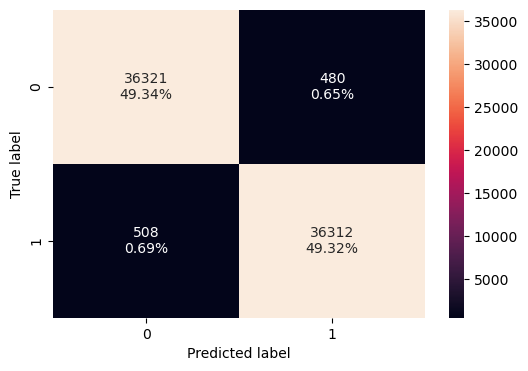

In [276]:
# creating confusion matrix
confusion_matrix_sklearn(ada, X_test, y_test)

#### XGBoost model

In [277]:
#XGBoost model cannot function with user_id data. We will therefore drop
df2 = df.drop(columns=['user_id'], axis=1)

In [278]:
# Type of scoring used to compare parameter combinations
scorer = metrics.make_scorer(metrics.f1_score)

In [279]:
# split data
X2 = df2.drop(["group_treatment"], axis = 1) # independant variables
y2 = df2[["group_treatment"]] # dependant variables

In [280]:
# Splitting the data into train and test sets
X2_train, X2_test, y2_train, y2_test = train_test_split(
    X2, y2, test_size=0.25, random_state=1, stratify=y2
)
print(X2_train.shape, X2_test.shape)

(220861, 5) (73621, 5)


In [282]:
# XGBoost model
xgb = XGBClassifier().fit(X2_train, y2_train)
xgb_pred = xgb.predict(X2_test)

In [290]:
# checking model performance on training set 
print("Training Performance\n")
xgb_train_perf = model_performance_classification_sklearn(xgb, X2_train, y2_train)
xgb_train_perf

Training Performance



,Accuracy,Recall,Precision,F1
0,0.986847,0.98681,0.98689,0.98685


In [291]:
# checking model performance on test set 
print("Test Performance\n")
xgb_test_perf = model_performance_classification_sklearn(xgb, X2_test, y2_test)
xgb_test_perf

Test Performance



,Accuracy,Recall,Precision,F1
0,0.98658,0.986203,0.986954,0.986578


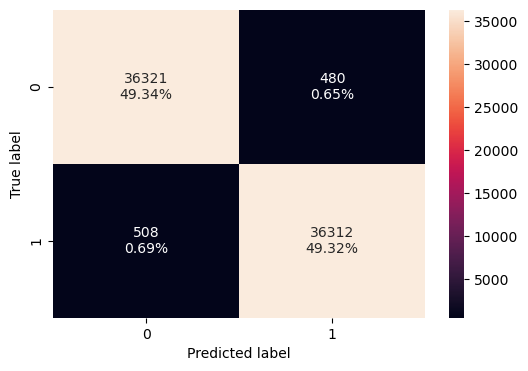

In [292]:
# creating confusion matrix
confusion_matrix_sklearn(xgb, X2_test, y2_test)

### Model results

- With our machine learning model we found that both the XGBoost model and Adaboost model had the same accuracy score. With a F1_score of 0.987 either model could be used for future prediction.
- Only 988 of the samples were misplaced out of the 294'482 samples. 

## Summary

- We compared the performance of the two websites using the t-test and p-value method. The result was a t-score of -0.85 and p-score of 0.39. 
- We concluded that switching to the new web page wouldn't have a significant difference on the user experience. And given that the t-test was -0.85, it is advised to continue with the old web page as is.


- With our machine learning model we found that both the XGBoost model and Adaboost model had the same accuracy score. With a F1_score of 0.987 either model could be used for future prediction.